## Libraries:

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import random
import os
import requests
import soundfile as sf
import librosa
from pydub import AudioSegment
import math
import IPython.display as ipd
import numpy as np

import scipy.io.wavfile as wav
from transformers import pipeline
import re

## GT Data Augmentation:

### Load and Split into training & testing

In [164]:
gt_data = pd.read_csv(r"D:\GP1\.venv\ipynb_Files\Code\CSV-Files\data_finetuning.csv",names=['Transcriptions', 'Audio_URLs'])
gt_data

Transcriptions  \
0       بالفضاء                                      ...   
1       فضاء                                         ...   
2       كوكب                                         ...   
3       رجل فضاء                                     ...   
4       صاروخ                                        ...   
...                                                  ...   
14857   إن المدير لا يكلمه بهذا الموضوع أبدا كأنه لا ...   
14858   وهوسامي هل يبني شهرته ويحقق أحلامه على حساب غ...   
14859   وذات صباح توجه إلى بيت قائده القديم حاملا معه...   
14860   استغرق القائد في الضحك وتعجب سامي لكن القائد ...   
14861   ألا تظنون مع سامي أن الدنيا حظوظ             ...   

                                              Audio_URLs  
0       https://www.ireadarabic.com/uploads/slides/1/...  
1       https://www.ireadarabic.com/uploads/slides/1/...  
2       https://www.ireadarabic.com/uploads/slides/1/...  
3       https://www.ireadarabic.com/uploads/slides/1/...  
4       https://www.ireadarabic.com/uploads/slides/1/...  
...                                                  ...  
14857   https://www.ireadarabic.com/uploads/slides/61...  
14858   https://www.ireadarabic.com/uploads/slides/61...  
14859   https://www.ireadarabic.com/uploads/slides/61...  
14860   https://www.ireadarabic.com/uploads/slides/61...  
14861   https://www.ireadarabic.com/uploads/slides/61...  

[14862 rows x 2 columns]

Splitting Ground Truth data to training & testing using 80-20 split:

In [165]:
train, test = train_test_split(gt_data, test_size=0.2, random_state=42)

#Reset index because of iheriting original index value from gt_data
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

train.shape, test.shape

((11889, 2), (2973, 2))

### Extracting URLs and renaming audio files:

Each audio file will be renamed using a unique random 5-digit numerical ID. This ID number will serve as a link between the extracted audio files and their corresponding transcriptions.

5-digit ID number is enough to uniquely represent each one of the 11889 audio files, as seen from this calculation:

⌈log_10(11889)⌉=5

total number of possible IDs with 5 digits: 10^5 = 100,000. Since 100k is greater than 11889, each audio file can be represented uniquely with 5-digit numerical IDs.

In [166]:
def generate_unique_ids(num_ids):
    random.seed(42)
    return random.sample(range(10000, 99999), num_ids)

num_audio_files = len(train["Audio_URLs"])
unique_ids = generate_unique_ids(num_audio_files)

train['TA_ID'] = unique_ids
train

Transcriptions  \
0       قالت باختصار شديد  والدكم قرر ترك عمله في الخ...   
1       سألت سحر أيها الفيل ترضع صغارك ولكنك تستعمل أ...   
2       قرأنا الرسالتين فإذا هما تحتويان على الكلام ن...   
3       وأخيرا ارتداها الأسد جميعها ثم جلس على صخرة م...   
4       استيقظ عمر صباح يوم الجمعة على رائحة شهية يحب...   
...                                                  ...   
11884   كنت أرتجف وأسناني bتصطكb من شدة البرد وأنا أت...   
11885   وفي نهاية الحفل تجمع الطلاب والتقطت لهم صورة ...   
11886    قالت ريما وهي تحاول الإمساك به من الأفضل لك ...   
11887   قالت أنا لم أنس الشرط لكنك مت                ...   
11888   هزت نور رأسها وذهبت إلى سريرها  لكن جدتها ناد...   

                                              Audio_URLs  TA_ID  
0       https://www.ireadarabic.com/uploads/slides/52...  93810  
1       https://www.ireadarabic.com/uploads/slides/16...  24592  
2       https://www.ireadarabic.com/uploads/slides/26...  13278  
3       https://www.ireadarabic.com/uploads/slides/34...  46048  
4       https://www.ireadarabic.com/uploads/slides/72...  42098  
...                                                  ...    ...  
11884   https://www.ireadarabic.com/uploads/slides/28...  61552  
11885   https://www.ireadarabic.com/uploads/slides/12...  16760  
11886   https://www.ireadarabic.com/uploads/slides/29...  85740  
11887   https://www.ireadarabic.com/uploads/slides/33...  66243  
11888   https://www.ireadarabic.com/uploads/slides/42...  26891  

[11889 rows x 3 columns]

Extracting each audio file and renaming them to their corresponding unique ID:

In [167]:
train['Audio_URLs'][0].split('/')[-1]

'8449895552ae0361f230c080dc19096f.mp3'

In [171]:
train_dir = r'D:\GP1\.venv\ipynb_Files\ASR_Data2\Train-Audios'
os.makedirs(train_dir, exist_ok=True)
len(os.listdir(train_dir))

0

In [172]:
for i in range(len(train)): 
    
    audio = train['Audio_URLs'][i]
    audio_name = train['Audio_URLs'][i].split('/')[-1] #for print purposes
    
    transc = train['Transcriptions'][i]
    id = train['TA_ID'][i]
    print('Audio File: ',audio_name,', Corresponding ID: ', id)

    response = requests.get(audio)

    d = audio.split('.')[-1]
    fn = str(id) + '.' + d

    with open(os.path.join(train_dir, fn), 'wb') as f:
        f.write(response.content)

    print("Renamed Audio:", fn)

Audio File:  8449895552ae0361f230c080dc19096f.mp3 , Corresponding ID:  93810
Renamed Audio: 93810.mp3
Audio File:  c725cde149a85a0f3a6fcf596d0f3844.mp3 , Corresponding ID:  24592
Renamed Audio: 24592.mp3
Audio File:  58e5385103a80ce2ec8585a0eb2e96c8.mp3 , Corresponding ID:  13278
Renamed Audio: 13278.mp3
Audio File:  68f0f55c711ec36bd618bce3d5fb4211.mp3 , Corresponding ID:  46048
Renamed Audio: 46048.mp3
Audio File:  c8e1424849b46c2bd215ba3a2e27aaf3.mp3 , Corresponding ID:  42098
Renamed Audio: 42098.mp3
Audio File:  89ac33354c9a33d540932d1946f04e06.mp3 , Corresponding ID:  39256
Renamed Audio: 39256.mp3
Audio File:  a0ddbbc7fa985e71a02dbe8f811ca2cc.mp3 , Corresponding ID:  28289
Renamed Audio: 28289.mp3
Audio File:  0400258e2d33178d0b11fa6a597b011e.mp3 , Corresponding ID:  23434
Renamed Audio: 23434.mp3
Audio File:  1f255f9e81827a3fedf2bdeab5245e26.mp3 , Corresponding ID:  98696
Renamed Audio: 98696.mp3
Audio File:  394c9cfb8eb716623b392400b844af42.mp3 , Corresponding ID:  81482
Renam

First Traing Checkpoint

In [173]:
train.to_csv('train-with-ids.csv',index=False)

log_10(2973)≈3.473 --> 4 after rounding to nearest who number
With 3 digits, you can represent up to 999 (10^3-1) unique IDs which is insufficient for 2973, but with 4 digits, up to 9999 (10^4-1) unique IDs can be generated which is more than enough. 

In [174]:
def generate_unique_ids2(num_ids):
    random.seed(42)
    return random.sample(range(1000, 9999), num_ids)

num_audio_files = len(test["Audio_URLs"])
unique_ids = generate_unique_ids2(num_audio_files)

test['TA_ID'] = unique_ids
test

Transcriptions  \
0      كبرت الشتول وأعطتbrخضارا طيبة                ...   
1      هذا التفاح أحمر                              ...   
2      في المطبعة  كبيرة تطبع                       ...   
3      دققت النظر في الصور في هذه الصورة ماما تسبح م...   
4      قالت سمكة السلمون نعم أنا سمكة ولي ذيل وزعانف...   
...                                                 ...   
2968   النملة والفيل                                ...   
2969   في الرحلة التالية أرسل أبو أسعد على ظهر الحما...   
2970   حكى للناس ما شاهده من غرائبbrفتعجبوا لأنه لم ...   
2971   لن أتابع الركض                               ...   
2972   انسجم الأطفال كثيرا وهم يحدثون رضوان عن حيهم ...   

                                             Audio_URLs  TA_ID  
0      https://www.ireadarabic.com/uploads/slides/93...   2824  
1      https://www.ireadarabic.com/uploads/slides/12...   1409  
2      https://www.ireadarabic.com/uploads/slides/20...   5506  
3      https://www.ireadarabic.com/uploads/slides/82...   5012  
4      https://www.ireadarabic.com/uploads/slides/15...   4657  
...                                                 ...    ...  
2968   https://www.ireadarabic.com/uploads/slides/27...   6704  
2969   https://www.ireadarabic.com/uploads/slides/46...   4410  
2970   https://www.ireadarabic.com/uploads/slides/53...   8790  
2971   https://www.ireadarabic.com/uploads/slides/13...   2222  
2972   https://www.ireadarabic.com/uploads/slides/41...   3456  

[2973 rows x 3 columns]

In [179]:
test_dir = r'D:\GP1\.venv\ipynb_Files\ASR_Data2\Test-Audios'
os.makedirs(test_dir, exist_ok=True)
len(os.listdir(test_dir))

0

In [180]:
for i in range(len(test)): 
    
    audio = test['Audio_URLs'][i]
    audio_name = test['Audio_URLs'][i].split('/')[-1] #for print purposes
    
    transc = test['Transcriptions'][i]
    id = test['TA_ID'][i]
    print('Audio File: ',audio_name,', Corresponding ID: ', id)

    response = requests.get(audio)

    d = audio.split('.')[-1]
    fn = str(id) + '.' + d

    with open(os.path.join(test_dir, fn), 'wb') as f:
        f.write(response.content)
        
    print("Renamed Audio:", fn)

Audio File:  b43ee87df3f2db5848b1e9d4193681eb.mp3 , Corresponding ID:  2824
Renamed Audio: 2824.mp3
Audio File:  2197cbf596d0fe9cadcf66070dd0421c.mp3 , Corresponding ID:  1409
Renamed Audio: 1409.mp3
Audio File:  692a79dee78be85b31a2b52a15593ebf.mp3 , Corresponding ID:  5506
Renamed Audio: 5506.mp3
Audio File:  2e17399041eb0410ae008aca79b9162a.mp3 , Corresponding ID:  5012
Renamed Audio: 5012.mp3
Audio File:  e75da566886bf134bf9a761048c51f27.mp3 , Corresponding ID:  4657
Renamed Audio: 4657.mp3
Audio File:  83fc7532a912cd697798373f83e3903e.mp3 , Corresponding ID:  3286
Renamed Audio: 3286.mp3
Audio File:  d266760d23fe9f98eb2718db4c270e63.mp3 , Corresponding ID:  2679
Renamed Audio: 2679.mp3
Audio File:  39d7be00a5e8512a6e8c7b072c301a37.mp3 , Corresponding ID:  9935
Renamed Audio: 9935.mp3
Audio File:  8853e5163d9b5cf69024ed7cb791a365.mp3 , Corresponding ID:  2424
Renamed Audio: 2424.mp3
Audio File:  732be19d0cb282e4889f4771a77fe2f4.mp3 , Corresponding ID:  7912
Renamed Audio: 7912.mp3


First Test Checkpoint

In [181]:
test.to_csv('test-with-ids.csv',index=False)

### Corrupted files removal: 

Checking for corrupted audio files in training data:

Intially we didn't realize our dataset would have corrupted audio files, we ran the mapping code for fine-tuning and faced this issue so we removed these corrupted audio files.

In [182]:
def is_corrupted(file_path):
    try:
        sf.read(file_path)
        return False  
    
    except Exception as e:
        print(f"Error reading {file_path}: {e}")
        return True  

In [184]:
len(os.listdir(train_dir))

11889

In [185]:
# Removing the corrupted audio files from the training train_directory based on SoundFile

corrupted_train = []  

for file_name in os.listdir(train_dir):

    file_path = os.path.join(train_dir, file_name)
    if is_corrupted(file_path):
        print(f"File {file_name} is corrupted. Removing...")

        os.remove(file_path)
        
        fn = os.path.splitext(file_name)[0]
        corrupted_train.append(fn)


Error reading D:\GP1\.venv\ipynb_Files\ASR_Data2\Train-Audios\10665.mp3: Error opening 'D:\\GP1\\.venv\\ipynb_Files\\ASR_Data2\\Train-Audios\\10665.mp3': File does not exist or is not a regular file (possibly a pipe?).
File 10665.mp3 is corrupted. Removing...
Error reading D:\GP1\.venv\ipynb_Files\ASR_Data2\Train-Audios\12900.mp3: Error opening 'D:\\GP1\\.venv\\ipynb_Files\\ASR_Data2\\Train-Audios\\12900.mp3': File does not exist or is not a regular file (possibly a pipe?).
File 12900.mp3 is corrupted. Removing...
Error reading D:\GP1\.venv\ipynb_Files\ASR_Data2\Train-Audios\14405.mp3: Error opening 'D:\\GP1\\.venv\\ipynb_Files\\ASR_Data2\\Train-Audios\\14405.mp3': File does not exist or is not a regular file (possibly a pipe?).
File 14405.mp3 is corrupted. Removing...
Error reading D:\GP1\.venv\ipynb_Files\ASR_Data2\Train-Audios\15383.mp3: Error opening 'D:\\GP1\\.venv\\ipynb_Files\\ASR_Data2\\Train-Audios\\15383.mp3': File does not exist or is not a regular file (possibly a pipe?).
F

In [186]:
corrupted_train[:5]  #this includes the IDs of corrupted train files

['10665', '12900', '14405', '15383', '15611']

In [187]:
len(corrupted_train) #we have 29 corrupted files

29

In [189]:
len(os.listdir(train_dir))

11860

In [190]:
len(os.listdir(test_dir))

2973

In [191]:
# Removing the corrupted audio files from the testing directory
    
corrupted_test = []  

for file_name in os.listdir(test_dir):

    file_path = os.path.join(test_dir, file_name)
    if is_corrupted(file_path):
        print(f"The file {file_name} is corrupted. Removing...")

        os.remove(file_path)

        file_name_without_extension = os.path.splitext(file_name)[0]
        corrupted_test.append(file_name_without_extension)


Error reading D:\GP1\.venv\ipynb_Files\ASR_Data2\Test-Audios\1612.mp3: Error opening 'D:\\GP1\\.venv\\ipynb_Files\\ASR_Data2\\Test-Audios\\1612.mp3': File does not exist or is not a regular file (possibly a pipe?).
The file 1612.mp3 is corrupted. Removing...
Error reading D:\GP1\.venv\ipynb_Files\ASR_Data2\Test-Audios\2162.mp3: Error opening 'D:\\GP1\\.venv\\ipynb_Files\\ASR_Data2\\Test-Audios\\2162.mp3': File does not exist or is not a regular file (possibly a pipe?).
The file 2162.mp3 is corrupted. Removing...
Error reading D:\GP1\.venv\ipynb_Files\ASR_Data2\Test-Audios\3442.mp3: Error opening 'D:\\GP1\\.venv\\ipynb_Files\\ASR_Data2\\Test-Audios\\3442.mp3': File does not exist or is not a regular file (possibly a pipe?).
The file 3442.mp3 is corrupted. Removing...
Error reading D:\GP1\.venv\ipynb_Files\ASR_Data2\Test-Audios\5834.mp3: Error opening 'D:\\GP1\\.venv\\ipynb_Files\\ASR_Data2\\Test-Audios\\5834.mp3': File does not exist or is not a regular file (possibly a pipe?).
The file

In [192]:
corrupted_test[:5] #IDs of corrupted test files

['1612', '2162', '3442', '5834', '6138']

In [193]:
len(corrupted_test)

6

In [194]:
len(os.listdir(test_dir))

2967

In [195]:
# Removing corrupted files from train dataset: 

for index, row in train.iterrows():
    id = row['TA_ID']
    
    if str(id) in corrupted_train:
        train.drop(index, inplace=True)

In [196]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11860 entries, 0 to 11888
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Transcriptions  11860 non-null  object
 1   Audio_URLs      11860 non-null  object
 2   TA_ID           11860 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 370.6+ KB


In [198]:
train.reset_index(drop=True,inplace=True)

In [199]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11860 entries, 0 to 11859
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Transcriptions  11860 non-null  object
 1   Audio_URLs      11860 non-null  object
 2   TA_ID           11860 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 278.1+ KB


In [200]:
# Removing corrupted audio files from the test dataset:

for index, row in test.iterrows():
    id = row['TA_ID']
    
    if str(id) in corrupted_test:
        test.drop(index, inplace=True)

In [201]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2967 entries, 0 to 2972
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Transcriptions  2967 non-null   object
 1   Audio_URLs      2967 non-null   object
 2   TA_ID           2967 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 92.7+ KB


In [202]:
test.reset_index(drop=True,inplace=True)

In [203]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2967 entries, 0 to 2966
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Transcriptions  2967 non-null   object
 1   Audio_URLs      2967 non-null   object
 2   TA_ID           2967 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 69.7+ KB


### Conversion to WAV format:

Now, converting these audio files to WAV format (for Whisper fine-tuning) and saving the audio files to the dataset:

In [205]:
output_dir1 = r'D:\GP1\.venv\ipynb_Files\ASR_Data2\train-wav' #to save the WAV audio files
os.makedirs(output_dir1, exist_ok=True)

def convert_audio_files(dir1, dataset, output_dir):
    for filename in os.listdir(dir1):
        if filename.endswith(".mp3"): 

            id = os.path.splitext(filename)[0]
            id = int(id)

            audio_path = os.path.join(dir1, filename)
            y, sr = sf.read(audio_path)
            wav_path = os.path.join(output_dir, f"{id}.wav")  

            sf.write(wav_path, y, sr)

            dataset.loc[dataset['TA_ID'] == id, 'Audio_WAV'] = wav_path

    return dataset


train_data = convert_audio_files(train_dir, train, output_dir1)
train_data.head()

Transcriptions  \
0   قالت باختصار شديد  والدكم قرر ترك عمله في الخ...   
1   سألت سحر أيها الفيل ترضع صغارك ولكنك تستعمل أ...   
2   قرأنا الرسالتين فإذا هما تحتويان على الكلام ن...   
3   وأخيرا ارتداها الأسد جميعها ثم جلس على صخرة م...   
4   استيقظ عمر صباح يوم الجمعة على رائحة شهية يحب...   

                                          Audio_URLs  TA_ID  \
0   https://www.ireadarabic.com/uploads/slides/52...  93810   
1   https://www.ireadarabic.com/uploads/slides/16...  24592   
2   https://www.ireadarabic.com/uploads/slides/26...  13278   
3   https://www.ireadarabic.com/uploads/slides/34...  46048   
4   https://www.ireadarabic.com/uploads/slides/72...  42098   

                                           Audio_WAV  
0  D:\GP1\.venv\ipynb_Files\ASR_Data2\train-wav\9...  
1  D:\GP1\.venv\ipynb_Files\ASR_Data2\train-wav\2...  
2  D:\GP1\.venv\ipynb_Files\ASR_Data2\train-wav\1...  
3  D:\GP1\.venv\ipynb_Files\ASR_Data2\train-wav\4...  
4  D:\GP1\.venv\ipynb_Files\ASR_Data2\train-wav\4...

In [208]:
len(os.listdir(output_dir1)), len(train_data), len(os.listdir(train_dir))

(11860, 11860, 11860)

In [207]:
train.to_csv('training-data1.csv',index=False)

In [209]:
output_dir2 = r'D:\GP1\.venv\ipynb_Files\ASR_Data2\test-wav'
os.makedirs(output_dir2, exist_ok=True)

test_data = convert_audio_files(test_dir, test, output_dir2)
test_data.head()

Transcriptions  \
0   كبرت الشتول وأعطتbrخضارا طيبة                ...   
1   هذا التفاح أحمر                              ...   
2   في المطبعة  كبيرة تطبع                       ...   
3   دققت النظر في الصور في هذه الصورة ماما تسبح م...   
4   قالت سمكة السلمون نعم أنا سمكة ولي ذيل وزعانف...   

                                          Audio_URLs  TA_ID  \
0   https://www.ireadarabic.com/uploads/slides/93...   2824   
1   https://www.ireadarabic.com/uploads/slides/12...   1409   
2   https://www.ireadarabic.com/uploads/slides/20...   5506   
3   https://www.ireadarabic.com/uploads/slides/82...   5012   
4   https://www.ireadarabic.com/uploads/slides/15...   4657   

                                           Audio_WAV  
0  D:\GP1\.venv\ipynb_Files\ASR_Data2\test-wav\28...  
1  D:\GP1\.venv\ipynb_Files\ASR_Data2\test-wav\14...  
2  D:\GP1\.venv\ipynb_Files\ASR_Data2\test-wav\55...  
3  D:\GP1\.venv\ipynb_Files\ASR_Data2\test-wav\50...  
4  D:\GP1\.venv\ipynb_Files\ASR_Data2\test-wav\46...

In [210]:
len(os.listdir(output_dir2)), len(test_data), len(os.listdir(test_dir))

(2967, 2967, 2967)

In [211]:
test.to_csv('testing-data1.csv',index=False)

### Removing audios with lengths greater than 30 seconds: 

Whisper is supposed to be fine-tuned on audio files with length <= 30 seconds.

So we check how many files in the training directory with length > 30 seconds.

In [212]:
files_greater = []

for filename in os.listdir(train_dir): 
    filepath = os.path.join(train_dir, filename)
    if filename.endswith(('.wav', '.mp3')):

        audio_data, sampling_rate = librosa.load(filepath, sr=None)
        duration_seconds = librosa.get_duration(y=audio_data, sr=sampling_rate)

        if duration_seconds > 30:

            print(f"File '{filename}' exceeds 30 seconds (Duration: {duration_seconds:.2f} seconds)")
            files_greater.append(filename)

File '10113.mp3' exceeds 30 seconds (Duration: 41.42 seconds)
File '10395.mp3' exceeds 30 seconds (Duration: 34.95 seconds)
File '10455.mp3' exceeds 30 seconds (Duration: 34.42 seconds)
File '10895.mp3' exceeds 30 seconds (Duration: 31.84 seconds)
File '11056.mp3' exceeds 30 seconds (Duration: 37.52 seconds)
File '11198.mp3' exceeds 30 seconds (Duration: 36.28 seconds)
File '11620.mp3' exceeds 30 seconds (Duration: 31.06 seconds)
File '11861.mp3' exceeds 30 seconds (Duration: 41.30 seconds)
File '12035.mp3' exceeds 30 seconds (Duration: 33.28 seconds)
File '12246.mp3' exceeds 30 seconds (Duration: 32.21 seconds)
File '13148.mp3' exceeds 30 seconds (Duration: 37.41 seconds)
File '13584.mp3' exceeds 30 seconds (Duration: 34.51 seconds)
File '13655.mp3' exceeds 30 seconds (Duration: 38.64 seconds)
File '13809.mp3' exceeds 30 seconds (Duration: 45.35 seconds)
File '14056.mp3' exceeds 30 seconds (Duration: 34.38 seconds)
File '14138.mp3' exceeds 30 seconds (Duration: 30.48 seconds)
File '14

In [213]:
len(files_greater)

367

In [214]:
files_greater_test = []

for filename in os.listdir(test_dir): #test_dir is the directory for testing audio files
    filepath = os.path.join(test_dir, filename)
    
    audio_data, sampling_rate = librosa.load(filepath, sr=None)
    duration_seconds = librosa.get_duration(y=audio_data, sr=sampling_rate)

    if duration_seconds > 30:

        print(f"File '{filename}' exceeds 30 seconds (Duration: {duration_seconds:.2f} seconds)")
        files_greater_test.append(filename)

len(files_greater_test)

File '1174.mp3' exceeds 30 seconds (Duration: 41.12 seconds)
File '1207.mp3' exceeds 30 seconds (Duration: 42.38 seconds)
File '1294.mp3' exceeds 30 seconds (Duration: 32.90 seconds)
File '1322.mp3' exceeds 30 seconds (Duration: 34.72 seconds)
File '1419.mp3' exceeds 30 seconds (Duration: 32.42 seconds)
File '1676.mp3' exceeds 30 seconds (Duration: 42.97 seconds)
File '1711.mp3' exceeds 30 seconds (Duration: 30.72 seconds)
File '1739.mp3' exceeds 30 seconds (Duration: 51.64 seconds)
File '1793.mp3' exceeds 30 seconds (Duration: 33.96 seconds)
File '1929.mp3' exceeds 30 seconds (Duration: 43.28 seconds)
File '1936.mp3' exceeds 30 seconds (Duration: 35.45 seconds)
File '1973.mp3' exceeds 30 seconds (Duration: 33.02 seconds)
File '2054.mp3' exceeds 30 seconds (Duration: 46.16 seconds)
File '2065.mp3' exceeds 30 seconds (Duration: 39.76 seconds)
File '2127.mp3' exceeds 30 seconds (Duration: 32.38 seconds)
File '2267.mp3' exceeds 30 seconds (Duration: 39.73 seconds)
File '2589.mp3' exceeds 

87

In [23]:
total_files = len(os.listdir(r'D:\GP1\.venv\ipynb_Files\ASR_Data2\train-wav'))
longer_than_30_seconds = len(files_greater)

percentage = (longer_than_30_seconds / total_files) * 100
print("Percentage of train files longer than 30 seconds:", "{:.3f}".format(percentage), "%")

Percentage of train files longer than 30 seconds: 3.193 %


In [24]:
total_files = len(os.listdir(r'D:\GP1\.venv\ipynb_Files\ASR_Data2\test-wav'))
longer_than_30_seconds = len(files_greater_test)

percentage = (longer_than_30_seconds / total_files) * 100
print("Percentage of test files longer than 30 seconds:", "{:.3f}".format(percentage), "%")

Percentage of test files longer than 30 seconds: 3.021 %


Given the small percentage of files with lengths greater than 30 seconds (3% out of 11k files, and 2% out of 2.9k), it would be more efficient to remove them entirely rather than manually segmenting them into 30-second chunks and aligning them with corresponding transcriptions, each also segmented to match the audio's 30-second endpoint.

In [221]:
wav_traindir = r'D:\GP1\.venv\ipynb_Files\ASR_Data2\train-wav'
wav_testdir = r'D:\GP1\.venv\ipynb_Files\ASR_Data2\test-wav'

In [225]:
files_greater[0].split('.')[0]

'10113'

In [4]:
# Removing the mp3 and wav train audio files > 30 seconds

for i in range(len(files_greater)):
    p1 = files_greater[i].split('.')[0]

    fp1 = os.path.join(train_dir, p1+'.mp3')
    fp2 = os.path.join(wav_traindir, p1+'.wav')
    os.remove(fp1)
    os.remove(fp2)

In [229]:
len(os.listdir(train_dir)), len(os.listdir(wav_traindir))

(11493, 11493)

In [5]:
# Removing the mp3 and wav test audio files > 30 seconds from directories

for i in range(len(files_greater_test)):
    p1 = files_greater_test[i].split('.')[0]

    fp1 = os.path.join(test_dir, p1+'.mp3')
    fp2 = os.path.join(wav_testdir, p1+'.wav')
    os.remove(fp1)
    os.remove(fp2)

In [231]:
len(os.listdir(test_dir)), len(os.listdir(wav_testdir))

(2880, 2880)

In [236]:
train_data.shape

(11860, 4)

In [237]:
for i in range(len(files_greater)):
    p1=files_greater[i].split('.')[0]

    index = train_data.index[train_data['TA_ID'] == int(p1)]
    ii = index[0]
    train_data.drop(ii, axis=0, inplace=True)

In [255]:
train_data.reset_index(drop=True,inplace=True)

In [256]:
train_data.shape

(11493, 4)

In [247]:
test_data.shape

(2880, 4)

In [248]:
files_greater_test[0]

'1174.mp3'

In [14]:
test_data.shape

(2967, 4)

In [261]:
for i in range(len(files_greater_test)):
    p1=files_greater_test[i].split('.')[0]

    index = test_data.index[test_data['TA_ID'] == int(p1)]
    if not index.empty:
        ii = index[0]
        test_data.drop(ii, axis=0, inplace=True)

In [16]:
test_data.shape

(2880, 4)

In [257]:
test_data.reset_index(drop=True,inplace=True)

In [263]:
train_data.to_csv('good-train.csv',index=False)
test_data.to_csv('good-test.csv',index=False)

### Adding random silence seconds to audio files:

We first start with finding out the lengths for each audio file in the train and test datasets:

In [6]:
train_data = pd.read_csv(r'D:\GP1\.venv\ipynb_Files\Code\NB-Files\good-train.csv')
test_data = pd.read_csv(r'D:\GP1\.venv\ipynb_Files\Code\NB-Files\good-test.csv')

In [7]:
train_data.columns

Index(['Transcriptions', 'Audio_URLs', 'TA_ID', 'Audio_WAV'], dtype='object')

Adding audio lengths to the train data:

In [8]:
def audio_length(audio_path):

    try:
        audio, sr = librosa.load(audio_path, sr=None)
        duration = librosa.get_duration(y=audio, sr=sr)

        return duration
    
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")

        return None

In [9]:
audio_paths1 = train_data['Audio_WAV']
audio_lengths1 = []

for audio_path in audio_paths1:

    length = audio_length(audio_path)

    if length is not None:
        audio_lengths1.append(length)

    else:
        audio_lengths1.append(None)  #if length cannot be determined, add None just incase

#add lengths to the train data in a new column
train_data['Audio_Lengths'] = audio_lengths1

In [10]:
train_data.head()

Transcriptions  \
0   قالت باختصار شديد  والدكم قرر ترك عمله في الخ...   
1   سألت سحر أيها الفيل ترضع صغارك ولكنك تستعمل أ...   
2   قرأنا الرسالتين فإذا هما تحتويان على الكلام ن...   
3   وأخيرا ارتداها الأسد جميعها ثم جلس على صخرة م...   
4   استيقظ عمر صباح يوم الجمعة على رائحة شهية يحب...   

                                          Audio_URLs  TA_ID  \
0   https://www.ireadarabic.com/uploads/slides/52...  93810   
1   https://www.ireadarabic.com/uploads/slides/16...  24592   
2   https://www.ireadarabic.com/uploads/slides/26...  13278   
3   https://www.ireadarabic.com/uploads/slides/34...  46048   
4   https://www.ireadarabic.com/uploads/slides/72...  42098   

                                           Audio_WAV  Audio_Lengths  
0  D:\GP1\.venv\ipynb_Files\ASR_Data2\train-wav\9...      12.120816  
1  D:\GP1\.venv\ipynb_Files\ASR_Data2\train-wav\2...       3.683265  
2  D:\GP1\.venv\ipynb_Files\ASR_Data2\train-wav\1...      19.226122  
3  D:\GP1\.venv\ipynb_Files\ASR_Data2\train-wav\4...      11.781224  
4  D:\GP1\.venv\ipynb_Files\ASR_Data2\train-wav\4...      24.120771

Adding audio lengths to the test data:

In [11]:
audio_paths2 = test_data['Audio_WAV']
audio_lengths2 = []

for audio_path in audio_paths2:

    length = audio_length(audio_path)

    if length is not None:
        audio_lengths2.append(length)

    else:
        audio_lengths2.append(None)  

test_data['Audio_Lengths'] = audio_lengths2

In [12]:
test_data.head()

Transcriptions  \
0   كبرت الشتول وأعطتbrخضارا طيبة                ...   
1   هذا التفاح أحمر                              ...   
2   في المطبعة  كبيرة تطبع                       ...   
3   دققت النظر في الصور في هذه الصورة ماما تسبح م...   
4   قالت سمكة السلمون نعم أنا سمكة ولي ذيل وزعانف...   

                                          Audio_URLs  TA_ID  \
0   https://www.ireadarabic.com/uploads/slides/93...   2824   
1   https://www.ireadarabic.com/uploads/slides/12...   1409   
2   https://www.ireadarabic.com/uploads/slides/20...   5506   
3   https://www.ireadarabic.com/uploads/slides/82...   5012   
4   https://www.ireadarabic.com/uploads/slides/15...   4657   

                                           Audio_WAV  Audio_Lengths  
0  D:\GP1\.venv\ipynb_Files\ASR_Data2\test-wav\28...       3.996735  
1  D:\GP1\.venv\ipynb_Files\ASR_Data2\test-wav\14...       1.593469  
2  D:\GP1\.venv\ipynb_Files\ASR_Data2\test-wav\55...       4.649796  
3  D:\GP1\.venv\ipynb_Files\ASR_Data2\test-wav\50...      15.792000  
4  D:\GP1\.venv\ipynb_Files\ASR_Data2\test-wav\46...       7.183673

Now we take a random sample of the training data and add silence seconds to those audio files such that their lengths remain <= 30 seconds. 

We realized soon after that reseting the index wouldn't be a good idea.

In [13]:
sampled_df = train_data.sample(frac=0.1, random_state=42)
# sampled_df = sampled_df.reset_index(drop=True)
sampled_df.head()

Transcriptions  \
5551   هديل تشم الزهور                              ...   
9045   أجابت إن التدرب في هذا المستشفىbr سيعطيني فرص...   
9970   ضربت زينة قدميها بالأرض وقالت أنا متأكدة أنها...   
7258   مر أسبوع على قرار غزل وكانت الأم تلاحظ بأن غز...   
6433   جلست على الكرسي المريحbrوفتحت فمها لفحص دقيق ...   

                                             Audio_URLs  TA_ID  \
5551   https://www.ireadarabic.com/uploads/slides/10...  13455   
9045   https://www.ireadarabic.com/uploads/slides/12...  93335   
9970   https://www.ireadarabic.com/uploads/slides/51...  75627   
7258   https://www.ireadarabic.com/uploads/slides/11...  57001   
6433   https://www.ireadarabic.com/uploads/slides/65...  91980   

                                              Audio_WAV  Audio_Lengths  
5551  D:\GP1\.venv\ipynb_Files\ASR_Data2\train-wav\1...       2.115918  
9045  D:\GP1\.venv\ipynb_Files\ASR_Data2\train-wav\9...      16.378776  
9970  D:\GP1\.venv\ipynb_Files\ASR_Data2\train-wav\7...      12.744000  
7258  D:\GP1\.venv\ipynb_Files\ASR_Data2\train-wav\5...      13.923265  
6433  D:\GP1\.venv\ipynb_Files\ASR_Data2\train-wav\9...       4.960454

In [12]:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1149 entries, 5551 to 2760
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Transcriptions  1149 non-null   object 
 1   Audio_URLs      1149 non-null   object 
 2   TA_ID           1149 non-null   int64  
 3   Audio_WAV       1149 non-null   object 
 4   Audio_Lengths   1149 non-null   float64
dtypes: float64(1), int64(1), object(3)
memory usage: 53.9+ KB


In [34]:
sampled_df['Audio_WAV'][0].split('\\')[-1]

'93810.wav'

- Want to add random seconds (not milliseconds) of silence, therefore we use math.floor(max_silence_duration) so that we ensure that we add integer number of seconds such that audio length remains less than 30 seconds.

- Any audio file with length >= 20 s, choose to add seconds either at beginning or end only. Any audio file with length < 20 s we can add either at beginnig or end or both. Choice either ways is random.

- 3 seconds of silence is the minimum number to add. Did max(3, math.floor(max_silence_duration)) to ensure that the range can never be zero and starts at minimum seconds to add.

In [66]:
# Function to add silence: 

def add_silence(audio_path):

    audio = AudioSegment.from_file(audio_path)

    max_length = 30000   #audio length shouldn't exceed 30k milliseconds, i.e. 30 seconds.
    current_length = len(audio) #length in milliseconds
    max_silence_duration = max_length - current_length

    audio_name = audio_path.split('\\')[-1]

    print(f"For {audio_name} of length {current_length} seconds, max silence duration allowed: {max_silence_duration} seconds")

    #randomly choose where to add silence seconds: beginning, end, or both
    silence_beginning = 0
    silence_end = 0

    choice = random.choice(['beginning', 'end', 'both'])
    if current_length > 20000:
        choice = random.choice(['beginning', 'end'])

    if choice == 'beginning':
        silence_beginning = min(random.randint(3, max(3, math.floor(max_silence_duration / 1000))), max_silence_duration // 1000)
    elif choice == 'end':
        silence_end = min(random.randint(3, max(3, math.floor(max_silence_duration / 1000))), max_silence_duration // 1000)
    elif choice == 'both':
        silence_beginning = min(random.randint(3, max(3, math.floor(max_silence_duration / 2000))), max_silence_duration // 2000)
        silence_end = min(random.randint(3, max(3, (math.floor(max_silence_duration / 1000) - silence_beginning))), (max_silence_duration - silence_beginning * 1000) // 1000)

    #creating new audio segment that includes orignal audio with added silence at beginning or end or both.
    #"AudioSegment.silent" adds silence to original audio "audio"
    silence = AudioSegment.silent(duration=silence_beginning*1000) + audio + AudioSegment.silent(duration=silence_end*1000)
    new_length = len(silence)/1000

    print(f"\nChoice for this audio: {choice}")
    print(f"Added {silence_beginning} seconds of silence to the beginning and {silence_end} seconds of silence to the end of the audio")

    print('\nLength now: ', new_length)
    print('\n\n')

    return silence

Simple test: 

In [67]:
sil = add_silence(sampled_df['Audio_WAV'][0])

For 93810.wav of length 12121 seconds, max silence duration allowed: 17879 seconds

Choice for this audio: beginning
Added 5 seconds of silence to the beginning and 0 seconds of silence to the end of the audio

Length now:  17.121





Testing to see if it worked:

In [68]:
ipd.Audio(sampled_df['Audio_WAV'][0])

In [69]:
sil

In [70]:
import os

#output directory
output_dir = r'D:\GP1\.venv\ipynb_Files\ASR_Data2\Added-Silence-To--Audios'
os.makedirs(output_dir, exist_ok=True)

for index, row in sampled_df.iterrows():

    ta_id = row['TA_ID']  
    output_audio = add_silence(row['Audio_WAV'])  

    outp = os.path.join(output_dir, f"silenced_{ta_id}_.wav")
    output_audio.export(outp, format="wav")

For 13455.wav of length 2116 seconds, max silence duration allowed: 27884 seconds

Choice for this audio: both
Added 9 seconds of silence to the beginning and 7 seconds of silence to the end of the audio

Length now:  18.116



For 93335.wav of length 16379 seconds, max silence duration allowed: 13621 seconds

Choice for this audio: both
Added 4 seconds of silence to the beginning and 9 seconds of silence to the end of the audio

Length now:  29.379



For 75627.wav of length 12744 seconds, max silence duration allowed: 17256 seconds

Choice for this audio: beginning
Added 15 seconds of silence to the beginning and 0 seconds of silence to the end of the audio

Length now:  27.744



For 57001.wav of length 13923 seconds, max silence duration allowed: 16077 seconds

Choice for this audio: beginning
Added 7 seconds of silence to the beginning and 0 seconds of silence to the end of the audio

Length now:  20.923



For 91980.wav of length 4960 seconds, max silence duration allowed: 25040 

In [72]:
sil_train_dir = r"D:\GP1\.venv\ipynb_Files\ASR_Data2\Added-Silence-To--Audios"
os.listdir(sil_train_dir)[:5]

['silenced_10053_.wav',
 'silenced_10110_.wav',
 'silenced_10131_.wav',
 'silenced_10425_.wav',
 'silenced_10683_.wav']

In [73]:
# Checking to see if it actually added silence seconds: 

file = os.listdir(sil_train_dir)[2]
file_path = os.path.join(sil_train_dir, file)
ipd.Audio(file_path)

In [74]:
len(os.listdir(sil_train_dir))

1149

Now that we added silence seconds to a random sample of audio files, we will take those audio files and add their paths to the dataset so that we can use this dataset to fine-tune Whisper on it.

In [75]:
train_data_cop = train_data.copy()
train_data_cop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11493 entries, 0 to 11492
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Transcriptions  11493 non-null  object 
 1   Audio_URLs      11493 non-null  object 
 2   TA_ID           11493 non-null  int64  
 3   Audio_WAV       11493 non-null  object 
 4   Audio_Lengths   11493 non-null  float64
dtypes: float64(1), int64(1), object(3)
memory usage: 449.1+ KB


Create a column called "Silenced_Paths", if audio file was augmented with silence then the value is the path to that audio file otherwise it is None.

In [76]:
def extract_id(filename):
    return int(filename.split('_')[1])

In [77]:
silenced_paths_dict = {}

for filename in os.listdir(sil_train_dir):
        id_from_filename = extract_id(filename)
        silenced_paths_dict[id_from_filename] = os.path.join(sil_train_dir, filename)

sampled_df['Silenced_Paths'] = sampled_df['TA_ID'].map(silenced_paths_dict)


In [78]:
silenced_paths_dict1 = {}

for filename in os.listdir(sil_train_dir):
        id_from_filename = extract_id(filename)
        silenced_paths_dict1[id_from_filename] = os.path.join(sil_train_dir, filename)

train_data_cop['Silenced_Paths'] = train_data_cop['TA_ID'].map(silenced_paths_dict1)


In [24]:
#display entire row: 

pd.set_option('display.max_colwidth', None)

In [79]:
train_data_cop.head()

Transcriptions  \
0                                                                         قالت باختصار شديد  والدكم قرر ترك عمله في الخارج والعودة للعيش معنا هنا لقد رتب الأمور مع خالكم سوف يأتي غدا صباحا                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1   سألت سحر أيها الفيل ترضع صغارك ولكنك تستعمل أنفك بدل يدك brفمن تكون                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
2                                                                                                                                                                       قرأنا الرسالتين فإذا هما تحتويان على الكلام نفسه فإذا هما مكتوبتان بالخط نفسه أيضا فعلمنا للتو أن شخصا ثالثا bدسb الرسالتين في حقيبة كل منا وقادنا بسهولة إلى الصلح                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
3                                         وأخيرا ارتداها الأسد جميعها ثم جلس على صخرة مرتفعة في الغابة ونظر إلى باقي الحيوانات من أعلى في عظمة وbجلالb                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
4                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [26]:
sampled_df.head()

Transcriptions  \
5551   هديل تشم الزهور                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
9045                                                                                                                                                                                                                                                                                                                                                          أجابت إن التدرب في هذا المستشفىbr سيعطيني فرصة لاكتساب خبرة مباشرة حولbr كيفية العمل الطبي وسيزيد فهمي لعلمbr الأحياء كما سيعطيني فكرة أفضل عنbr العمل تحت الضغط وتقوية مهارات التواصل                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       
9970                                                                                                                                                                                                           ضربت زينة قدميها بالأرض وقالت أنا متأكدة أنها ورقتي أناbrاسمك ليس مكتوب عليها رد يوسف بغضب واسمك أيضا أجابت زينة                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            
7258                                                                                                                                                                                                                                                 مر أسبوع على قرار غزل وكانت الأم تلاحظ بأن غزل تغيرت وأصبحت تعتاد على مرضها وتحبه وانتظمت في نظامها الغذائي وبأخذ الحقن في موعدها                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [80]:
print(train_data_cop['Audio_WAV'][0])
print(train_data_cop['Silenced_Paths'][0])

D:\GP1\.venv\ipynb_Files\ASR_Data2\train-wav\93810.wav
D:\GP1\.venv\ipynb_Files\ASR_Data2\Added-Silence-To--Audios\silenced_93810_.wav


In [81]:
print(train_data_cop['Audio_WAV'][14])
print(train_data_cop['Silenced_Paths'][14])

D:\GP1\.venv\ipynb_Files\ASR_Data2\train-wav\13905.wav
D:\GP1\.venv\ipynb_Files\ASR_Data2\Added-Silence-To--Audios\silenced_13905_.wav


In [82]:
inx = train_data_cop.index[~train_data_cop['Silenced_Paths'].isna()]
inx

Int64Index([    0,    14,    19,    33,    35,    39,    41,    47,    50,
               63,
            ...
            11385, 11400, 11406, 11420, 11441, 11442, 11451, 11452, 11458,
            11491],
           dtype='int64', length=1149)

Visualizing added silence seconds:

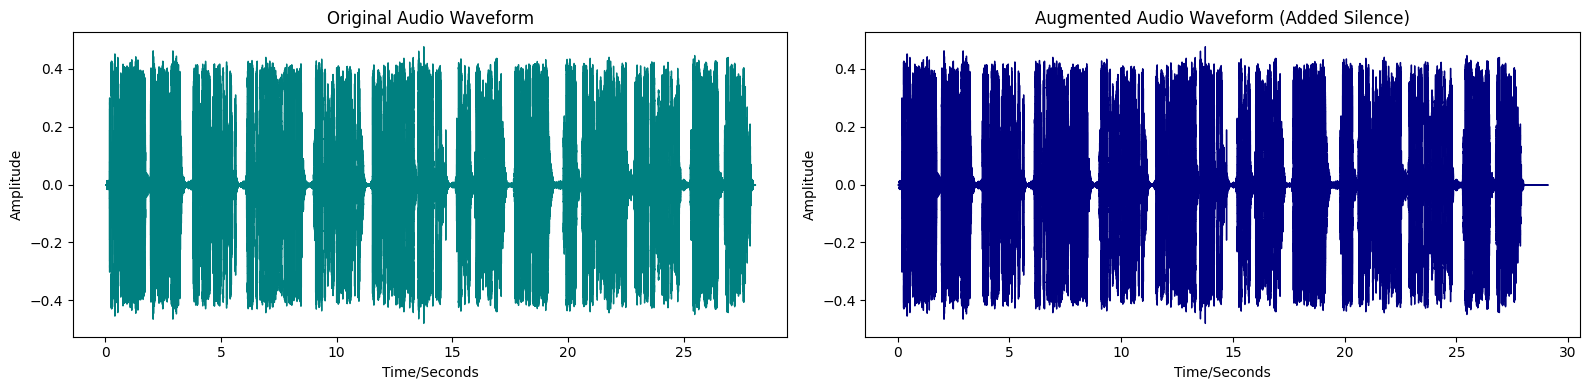

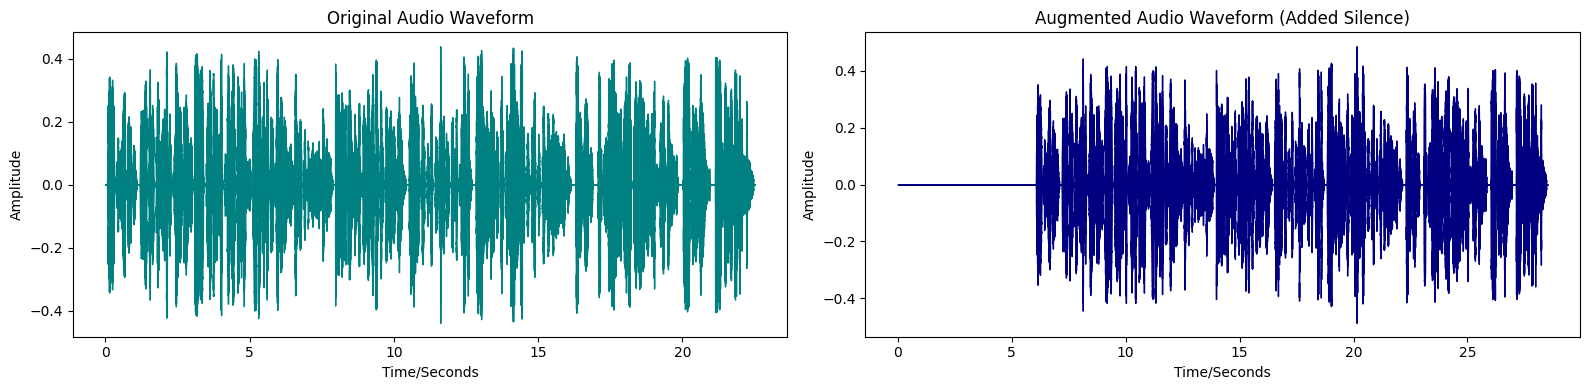

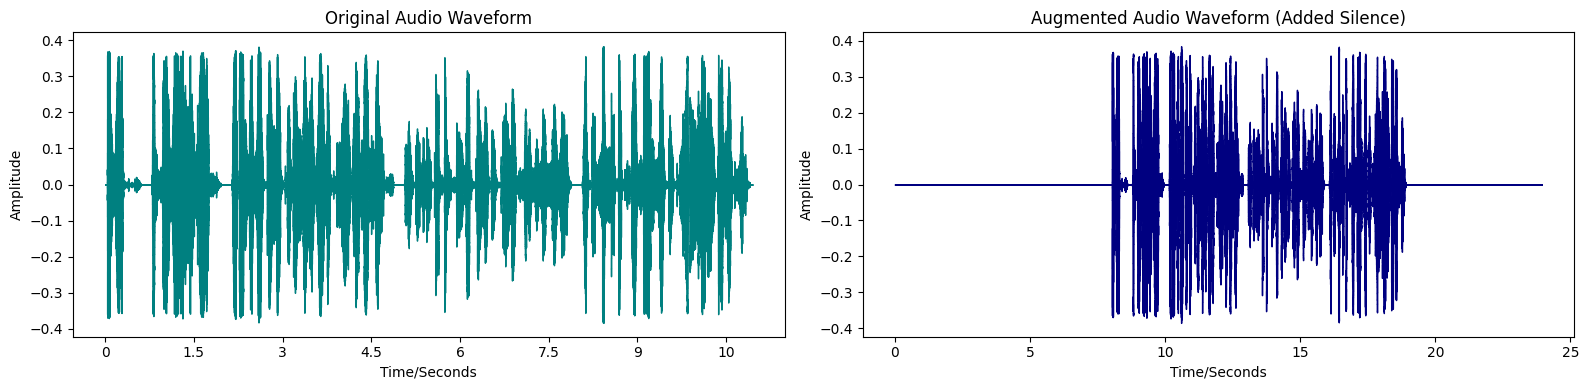

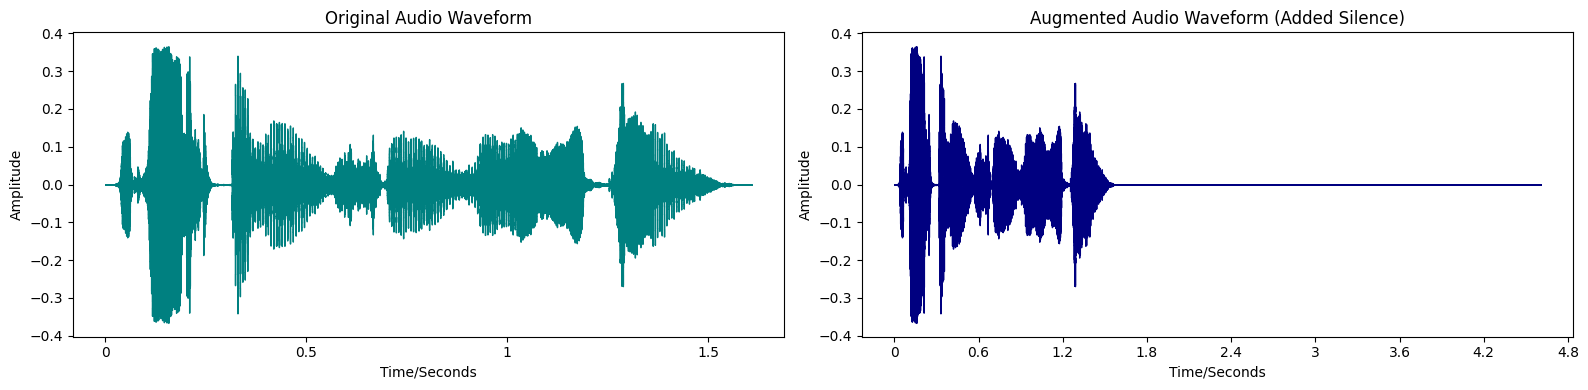

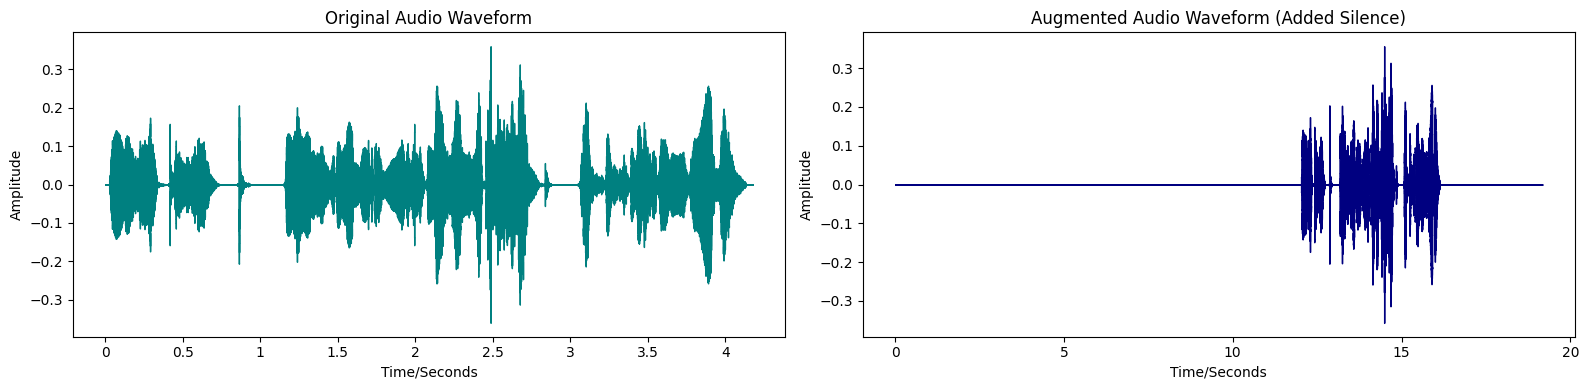

In [101]:
import matplotlib.pyplot as plt 
random.seed(42)

for i in range(5):
    random_index = random.choice(inx)
    y, sr = librosa.load(train_data_cop['Audio_WAV'][random_index])
    
    # Load the silenced audio from sampled_df
    y_silenced, sr_silenced = librosa.load(sampled_df['Silenced_Paths'][random_index])

    # Create a figure with two subplots side by side
    fig, axes = plt.subplots(1, 2, figsize=(16, 4))

    # Plot the waveform of the unsilenced audio on the first subplot
    librosa.display.waveshow(y, sr=sr, ax=axes[0], color='#008080')
    axes[0].set_title('Original Audio Waveform')
    axes[0].set_xlabel('Time/Seconds')
    axes[0].set_ylabel('Amplitude')

    # Plot the waveform of the silenced audio on the second subplot
    librosa.display.waveshow(y_silenced, sr=sr_silenced, ax=axes[1], color='#000080')
    axes[1].set_title('Augmented Audio Waveform (Added Silence)')
    axes[1].set_xlabel('Time/Seconds')
    axes[1].set_ylabel('Amplitude')

    plt.tight_layout()
    plt.show()


Combining the paths from regular audio files and augmented audio files into one column "All_Audio_Paths".

In [84]:
train_data_cop['All_Audios_Paths'] = np.where(train_data_cop['Silenced_Paths'].isna(), train_data_cop['Audio_WAV'], train_data_cop['Silenced_Paths'])
train_data_cop

Transcriptions  \
0                                                                                                                                                                         قالت باختصار شديد  والدكم قرر ترك عمله في الخارج والعودة للعيش معنا هنا لقد رتب الأمور مع خالكم سوف يأتي غدا صباحا                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1                                                                                                   سألت سحر أيها الفيل ترضع صغارك ولكنك تستعمل أنفك بدل يدك brفمن تكون                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
2                                                                                                                                                                                                                                                                       قرأنا الرسالتين فإذا هما تحتويان على الكلام نفسه فإذا هما مكتوبتان بالخط نفسه أيضا فعلمنا للتو أن شخصا ثالثا bدسb الرسالتين في حقيبة كل منا وقادنا بسهولة إلى الصلح                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
3                                                                                                                                         وأخيرا ارتداها الأسد جميعها ثم جلس على صخرة مرتفعة في الغابة ونظر إلى باقي الحيوانات من أعلى في عظمة وbجلالb                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     
4                                                                                             

In [85]:
train_data_cop.to_csv('training-checkpoint-semifin.csv',index=False)
sampled_df.to_csv('sampled-df.csv',index=False)
test_data.to_csv('test-checkpoint-semifin.csv',index=False)

### Removing English letters:

In [6]:
def contains_english(text):
    # Regular expression to match English letters
    english_pattern = re.compile(r'[a-zA-Z]')
    return bool(english_pattern.search(text))


train['contains_english'] = train['Transcriptions'].apply(contains_english)

# Filter the DataFrame to show rows where English letters are detected
english_letters_train = train[train['contains_english']]

# Print the rows where English letters are detected
print(english_letters_train)


                                          Transcriptions  \
1       سألت سحر أيها الفيل ترضع صغارك ولكنك تستعمل أ...   
2       قرأنا الرسالتين فإذا هما تحتويان على الكلام ن...   
3       وأخيرا ارتداها الأسد جميعها ثم جلس على صخرة م...   
4       استيقظ عمر صباح يوم الجمعة على رائحة شهية يحب...   
5       كان هذا الجار رجلا له رأي سديد وقلب من ذهب ول...   
...                                                  ...   
11479    قالت الآنسة صفاء وهزت ميرة رأسها BR موافقة ل...   
11482   لكنها كانت تراجع إجاباتها وتسألbr نفسها هل أح...   
11486   زنابق الماء العملاقة لها جذورbr تمتد تحت الما...   
11488   كنت أرتجف وأسناني bتصطكb من شدة البرد وأنا أت...   
11489   وفي نهاية الحفل تجمع الطلاب والتقطت لهم صورة ...   

                                              Audio_URLs  TA_ID  \
1       https://www.ireadarabic.com/uploads/slides/16...  24592   
2       https://www.ireadarabic.com/uploads/slides/26...  13278   
3       https://www.ireadarabic.com/uploads/slides/34...  46048   
4       htt

In [7]:
test['contains_english'] = test['Transcriptions'].apply(contains_english)

# Filter the DataFrame to show rows where English letters are detected
english_letters_test = test[test['contains_english']]

# Print the rows where English letters are detected
print(english_letters_test)


                                         Transcriptions  \
0      كبرت الشتول وأعطتbrخضارا طيبة                ...   
3      دققت النظر في الصور في هذه الصورة ماما تسبح م...   
7       بأنني bمميزb                                ...   
8      قبل أن أصل بقليلBR أسمع ترنيمة جميلةBR       ...   
9      فتح عمر لجدته باب سيارة الأجرة المنتظرة أمام ...   
...                                                 ...   
2862   سمعنا صراخه المعتاد ما هذا الصراخbr من يصرخ ه...   
2864   ألا تحبون الصيف وهذه الأجواء الجميلةbrكان واض...   
2865   في مساء اليوم التالي خرج الرفاق الثلاثة نحو b...   
2869   ابتسمت لبنى وأكملت إنه يعشق النظر إلى نفسه في...   
2877   حكى للناس ما شاهده من غرائبbrفتعجبوا لأنه لم ...   

                                             Audio_URLs  TA_ID  \
0      https://www.ireadarabic.com/uploads/slides/93...   2824   
3      https://www.ireadarabic.com/uploads/slides/82...   5012   
7      https://www.ireadarabic.com/uploads/slides/27...   9935   
8      https://www.ireadara

In [1]:
train = train[~train['contains_english']]

train = train.drop(columns=['contains_english'])

test = test[~test['contains_english']]

test = test.drop(columns=['contains_english'])

In [13]:
train.to_csv('train-done-augm.csv',index=False)
test.to_csv('test-done-augm.csv',index=False)